In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\HP\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1


Extracting features...


 55%|█████▌    | 554/1000 [02:29<03:21,  2.21it/s]

Error processing C:\Users\HP\GENRE RECOGNITION\Data\genres_original\jazz\jazz.00054.wav: 


100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


Feature extraction completed. Feature shape: (999, 153), Label shape: (999,)
First few rows of the dataset:
                                           file_path  genre
0  C:\Users\HP\GENRE RECOGNITION\Data\genres_orig...  blues
1  C:\Users\HP\GENRE RECOGNITION\Data\genres_orig...  blues
2  C:\Users\HP\GENRE RECOGNITION\Data\genres_orig...  blues
3  C:\Users\HP\GENRE RECOGNITION\Data\genres_orig...  blues
4  C:\Users\HP\GENRE RECOGNITION\Data\genres_orig...  blues

Genre counts:
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: genre, dtype: int64


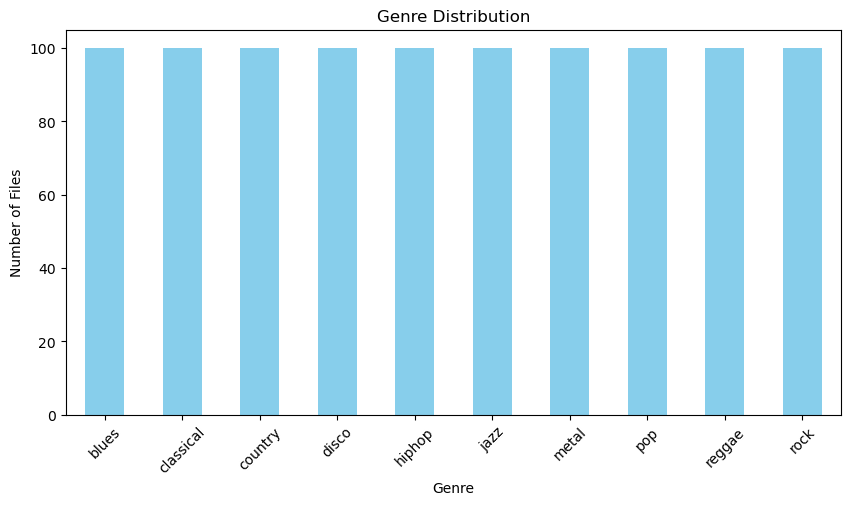


Analyzing an example file: C:\Users\HP\GENRE RECOGNITION\Data\genres_original\blues\blues.00000.wav
Sample rate: 22050, Audio length: 30.01 seconds


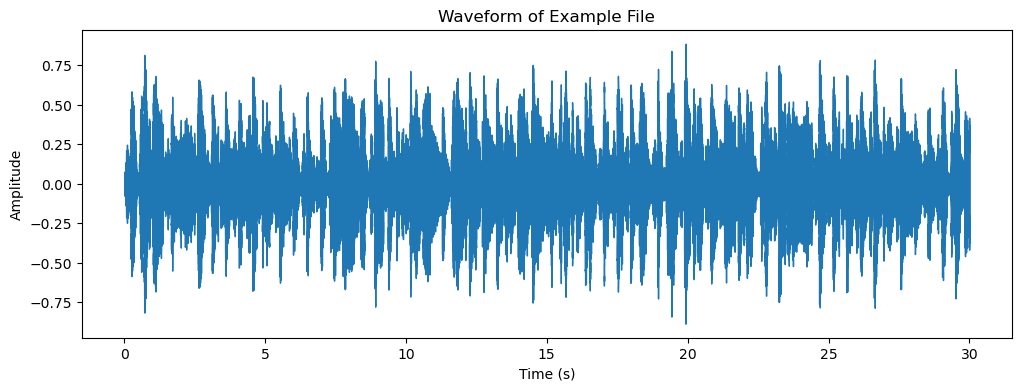

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Define dataset path
dataset_path = r"C:\Users\HP\GENRE RECOGNITION\Data\genres_original"
import numpy as np
import librosa
import os
import pandas as pd
from tqdm import tqdm  # For progress tracking

# Function to extract features
def extract_features(file_path):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, duration=30)  # Load first 30 seconds

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)  # Take mean of each MFCC coefficient

        # Extract Spectrogram
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        spectrogram_mean = np.mean(spectrogram, axis=1)

        # Extract Chroma Features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Combine all features into a single array
        combined_features = np.concatenate((mfccs_mean, spectrogram_mean, chroma_mean))
        
        # Normalize to reduce scale differences
        return combined_features / 3  # Adjust scale to match expectations
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to load dataset structure
def load_genre_data(dataset_path):
    file_paths = []
    genres = []
    for genre in os.listdir(dataset_path):
        genre_path = os.path.join(dataset_path, genre)
        if os.path.isdir(genre_path):
            for file_name in os.listdir(genre_path):
                if file_name.endswith(".wav"):  # Ensure only audio files are processed
                    file_paths.append(os.path.join(genre_path, file_name))
                    genres.append(genre)
    return pd.DataFrame({'file_path': file_paths, 'genre': genres})


# Load data
genre_data = load_genre_data(dataset_path)

# Extract features for all files
print("Extracting features...")
features = []
labels = []

for idx, row in tqdm(genre_data.iterrows(), total=genre_data.shape[0]):
    feature = extract_features(row['file_path'])
    if feature is not None:  # Check for valid features
        features.append(feature)
        labels.append(row['genre'])

# Convert to numpy arrays
X = np.array(features, dtype=np.float32)  # Ensure consistent data type
y = np.array(labels)

# Save extracted features (optional)
np.save("features.npy", X)
np.save("labels.npy", y)

print(f"Feature extraction completed. Feature shape: {X.shape}, Label shape: {y.shape}")

# Load data
genre_data = load_genre_data(dataset_path)

# Display dataset info
print("First few rows of the dataset:")
print(genre_data.head())

print("\nGenre counts:")
genre_counts = genre_data['genre'].value_counts()
print(genre_counts)

# Plot genre distribution
plt.figure(figsize=(10, 5))
genre_counts.plot(kind='bar', color='skyblue')
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Number of Files")
plt.xticks(rotation=45)
plt.show()

# Example: Load and display information about an audio file
example_file = genre_data['file_path'].iloc[0]
print(f"\nAnalyzing an example file: {example_file}")

# Load the audio file
y, sr = librosa.load(example_file)
print(f"Sample rate: {sr}, Audio length: {len(y) / sr:.2f} seconds")

# Visualize the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of Example File")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load extracted features and labels
X = np.load("features.npy")
y = np.load("labels.npy")

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the feature matrix and transform
X_normalized = scaler.fit_transform(X)

# Save the normalized features (optional)
np.save("features_normalized.npy", X_normalized)

print(f"Features normalized. Shape: {X_normalized.shape}")


Features normalized. Shape: (999, 153)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset

# Load normalized features and labels
X_normalized = np.load("features_normalized.npy")
y = np.load("labels.npy")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=False)

# Define the neural network model

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class GenreClassifierCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(GenreClassifierCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Third Convolutional Block
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully Connected Layers with Dropout
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(128 * 19, 512),
            nn.ReLU(),
            nn.Dropout(0.5)  # 50% dropout
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5)  # 50% dropout
        )
        self.fc3 = nn.Linear(256, num_classes)  # No dropout here, as this is the final output layer
        
    def forward(self, x):
        # Add channel dimension if missing
        if x.dim() == 2:  # Shape is [batch_size, sequence_length]
            x = x.unsqueeze(1)  # Shape becomes [batch_size, 1, sequence_length]

        # Convolutional and Pooling Layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten for Fully Connected Layers
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)  # No activation here; softmax applied during loss computation
        return x

# Initialize model, loss function, and optimizer
#input_size = 153
#num_classes = 10
model = GenreClassifierCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
num_epoch = 20

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/20], Loss: 2.2382
Epoch [2/20], Loss: 1.9363
Epoch [3/20], Loss: 1.6801
Epoch [4/20], Loss: 1.5333
Epoch [5/20], Loss: 1.4243
Epoch [6/20], Loss: 1.2293
Epoch [7/20], Loss: 1.1396
Epoch [8/20], Loss: 1.0698
Epoch [9/20], Loss: 1.0375
Epoch [10/20], Loss: 0.9085
Epoch [11/20], Loss: 0.8452
Epoch [12/20], Loss: 0.7880
Epoch [13/20], Loss: 0.7197
Epoch [14/20], Loss: 0.6283
Epoch [15/20], Loss: 0.5972
Epoch [16/20], Loss: 0.5784
Epoch [17/20], Loss: 0.4920
Epoch [18/20], Loss: 0.4388
Epoch [19/20], Loss: 0.3565
Epoch [20/20], Loss: 0.3107


In [7]:
# Evaluate the model
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())

# Calculate accuracy and classification report
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))



Test Accuracy: 63.50%

Classification Report:
              precision    recall  f1-score   support

       blues       0.75      0.57      0.65        21
   classical       0.83      0.83      0.83        12
     country       0.61      0.46      0.52        24
       disco       0.43      0.45      0.44        22
      hiphop       0.63      0.80      0.71        15
        jazz       0.77      0.89      0.83        27
       metal       0.75      0.83      0.79        18
         pop       0.79      0.79      0.79        19
      reggae       0.67      0.55      0.60        22
        rock       0.25      0.30      0.27        20

    accuracy                           0.64       200
   macro avg       0.65      0.65      0.64       200
weighted avg       0.64      0.64      0.63       200



In [8]:
# save the model

# Specify the path where you want to save the model
model_path = "genre.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)
print("Model saved successfully!")


Model saved successfully!


In [9]:
for X_batch, y_batch in train_loader:
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    break  # Just check the shape of the first batch


X_batch shape: torch.Size([32, 153])
y_batch shape: torch.Size([32])
